In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.2.0
/device:GPU:0


In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content/drive/My Drive/Deep Learning/Class',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
get_data_extract()

4996284416/4996278331 [==============================] - 555s 0us/step
Dataset downloaded and extracted!


In [ ]:
!ls '/content/drive/My Drive/Deep Learning/Class/food-101'

images	license_agreement.txt  meta  README.txt


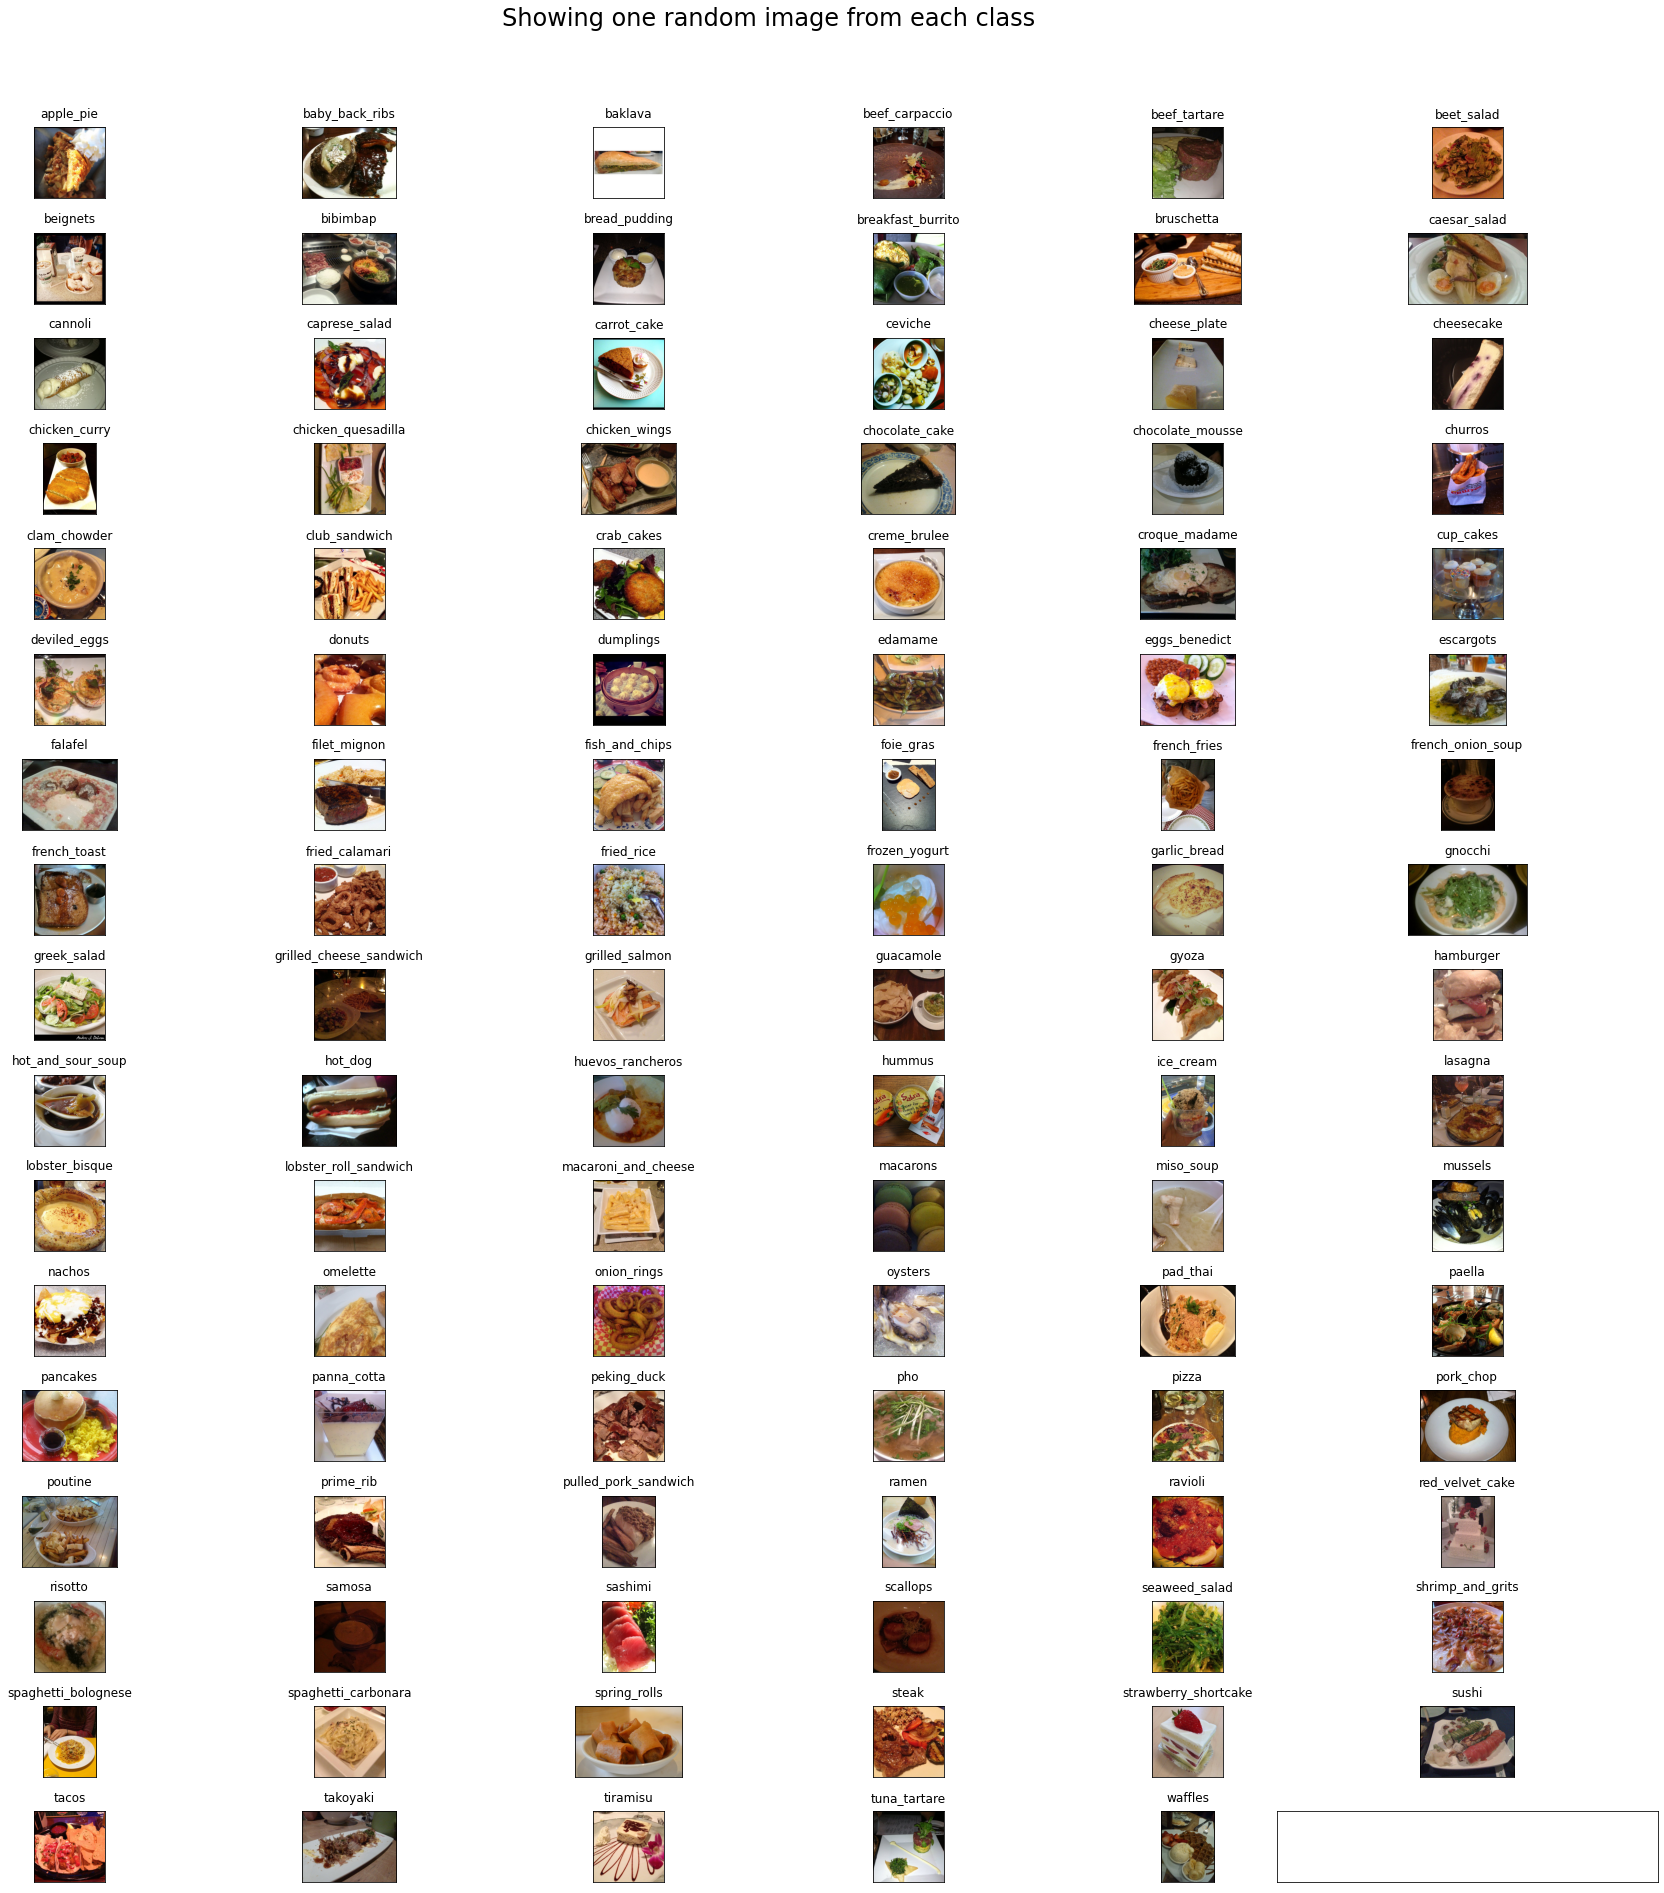

In [ ]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/drive/My Drive/Deep Learning/Class/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    plt.setp(ax, xticks=[],yticks=[])
    plt.tight_layout()

In [ ]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
%cd /
print("Creating train data...")
prepare_data('/content/drive/My Drive/Deep Learning/Class/food-101/meta/train.txt', '/content/drive/My Drive/Deep Learning/Class/food-101/images', '/content/drive/My Drive/Deep Learning/Class/food-101/meta/train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [ ]:
print("Creating test data...")
prepare_data('/content/drive/My Drive/Deep Learning/Class/food-101/meta/test.txt', '/content/drive/My Drive/Deep Learning/Class/food-101/images', '/content/drive/My Drive/Deep Learning/Class/food-101/meta/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("/content/drive/My Drive/Deep Learning/Class/food-101/meta/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("/content/drive/My Drive/Deep Learning/Class/food-101/meta/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [ ]:
del foods_sorted[0] 

In [ ]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [ ]:
food_list = ['apple_pie','pizza','omelette']
src_train = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/train'
dest_train = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/train_mini'
src_test = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/test'
dest_test = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("/content/drive/My Drive/Deep Learning/Class/food-101/meta/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("/content/drive/My Drive/Deep Learning/Class/food-101/meta/test_mini")])
print(test_files)

Total number of samples in test folder
750


In [ ]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/train_mini'
validation_data_dir = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('Classmodel_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87916544/87910968 [==============================] - 3s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 1.0905 - accuracy: 0.4400
Epoch 00001: val_loss improved from inf to 0.92108, saving model to best_model_3class.hdf5
140/140 [==============================] - 64s 461ms/step - loss: 1.0905 - accuracy: 0.4400 - val_loss: 0.9211 - val_accuracy: 0.6399
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.8797 - accuracy: 0.6419
Epoch 00002: val_loss improved from 0.92108 to 0.73626, saving model to best_model_3class.hdf5
140/140 [==============================] - 62s 445ms/step - loss: 0.8797 - accuracy: 0.6419 - val_loss: 0.7363 - val_accuracy: 0.7677
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.7301
Epoch 00003: val_loss improved fro

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

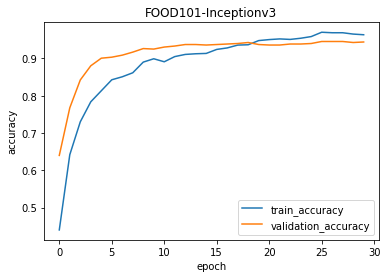

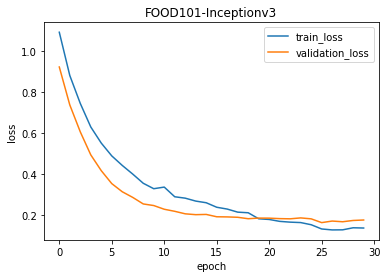

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 5.21 s, sys: 147 ms, total: 5.36 s
Wall time: 5.3 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://images-gmi-pmc.edge-generalmills.com/75593ed5-420b-4782-8eae-56bdfbc2586b.jpg
!wget -O pizza.jpg https://www.simplyrecipes.com/wp-content/uploads/2019/09/easy-pepperoni-pizza-lead-4-768x1075.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg

--2020-07-30 04:57:14--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   228KB/s    in 0.3s    

2020-07-30 04:57:15 (228 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2020-07-30 04:57:15--  https://images-gmi-pmc.edge-generalmills.com/75593ed5-420b-4782-8eae-56bdfbc2586b.jpg
Resolving images-gmi-pmc.edge-generalmills.com (images-gmi-pmc.edge-generalmills.com)... 192.229.163.76
Connecting to images-gmi-pmc.edge-generalmills.com (images-gmi-pmc.edge-generalmills.com)|192.229.163.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83666 (82K) [image/jpg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[=====

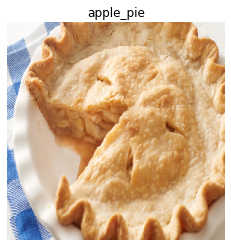

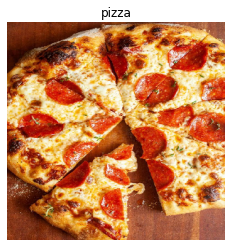

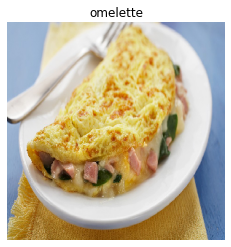

In [ ]:
images = []
images.append('applepie.jpg')
images.append('pizza.jpg')
images.append('omelette.jpg')
predict_class(model_best, images, True)

In [ ]:
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("/content/drive/My Drive/Deep Learning/Class/food-101/meta/train_mini")])
print(train_files)

Total number of samples in train folder
8250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in test_mini folder")
test_files = sum([len(files) for i, j, files in os.walk("/content/drive/My Drive/Deep Learning/Class/food-101/meta/test_mini")])
print(test_files)

Total number of samples in test_mini folder
2750


In [ ]:
# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/train_mini'
validation_data_dir = '/content/drive/My Drive/Deep Learning/Class/food-101/meta/test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])


model.save('/content/drive/My Drive/Deep Learning/Class/model_trained_3class.hdf5')


Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.
Epoch 1/30
515/515 [==============================] - ETA: 0s - loss: 2.1482 - accuracy: 0.3524
Epoch 00001: val_loss improved from inf to 1.49201, saving model to best_model_11class.hdf5
515/515 [==============================] - 231s 449ms/step - loss: 2.1482 - accuracy: 0.3524 - val_loss: 1.4920 - val_accuracy: 0.7039
Epoch 2/30
515/515 [==============================] - ETA: 0s - loss: 1.3520 - accuracy: 0.6637
Epoch 00002: val_loss improved from 1.49201 to 0.82815, saving model to best_model_11class.hdf5
515/515 [==============================] - 230s 447ms/step - loss: 1.3520 - accuracy: 0.6637 - val_loss: 0.8282 - val_accuracy: 0.8304
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 0.9667 - accuracy: 0.7576
Epoch 00003: val_loss improved from 0.82815 to 0.58247, saving model to best_model_11class.hdf5
515/515 [==============================] - 237s 461ms/step - loss: 0.966

In [ ]:

model.save('/content/drive/My Drive/Deep Learning/Class/model/model_trained_3class.h5')

In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'bibimbap': 2,
 'cup_cakes': 3,
 'foie_gras': 4,
 'french_fries': 5,
 'garlic_bread': 6,
 'pizza': 7,
 'spaghetti_carbonara': 8,
 'spring_rolls': 9,
 'strawberry_shortcake': 10}

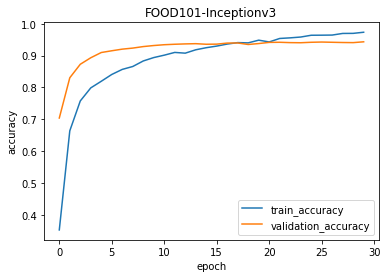

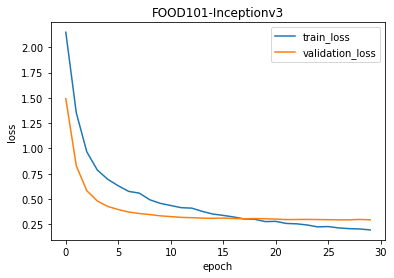

In [ ]:
plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

CPU times: user 5.88 s, sys: 150 ms, total: 6.03 s
Wall time: 5.96 s


In [ ]:
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
!wget -O pizza.jpg https://www.hungryhowies.com/sites/default/files/styles/menu_item_280x175/public/images/menu-items/thumbnails/meateaters.png?itok=unS-SVJl
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1


--2020-07-30 08:16:05--  https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
Resolving www.publicdomainpictures.net (www.publicdomainpictures.net)... 172.67.2.204, 104.20.45.162, 104.20.44.162, ...
Connecting to www.publicdomainpictures.net (www.publicdomainpictures.net)|172.67.2.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51698 (50K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>]  50.49K  --.-KB/s    in 0.001s  

2020-07-30 08:16:05 (78.4 MB/s) - ‘cupcakes.jpg’ saved [51698/51698]

--2020-07-30 08:16:06--  https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4154557 (4.0M) [image/jpeg]
Saving to: ‘springrolls.jpg

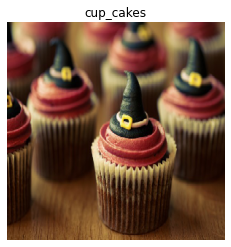

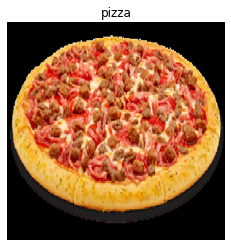

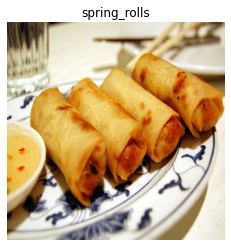

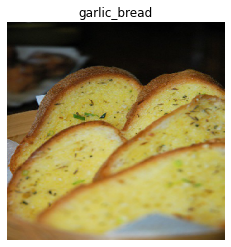

In [ ]:
images = []
images.append('cupcakes.jpg')
images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)